<a href="https://colab.research.google.com/github/ghanbarzadeh/Course_MachineVision_2021/blob/master/CHW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Blob detection

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial

In [2]:
!wget https://github.com/ghanbarzadeh/Course_MachineVision_2021/raw/master/resources/sunflower.jpg

--2021-11-06 16:47:53--  https://github.com/ghanbarzadeh/Course_MachineVision_2021/raw/master/resources/sunflower.jpg
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ghanbarzadeh/Course_MachineVision_2021/master/resources/sunflower.jpg [following]
--2021-11-06 16:47:53--  https://raw.githubusercontent.com/ghanbarzadeh/Course_MachineVision_2021/master/resources/sunflower.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149251 (146K) [image/jpeg]
Saving to: ‘sunflower.jpg’

sunflower.jpg       100%[===================>] 145.75K  --.-KB/s    in 0.002s  

2021-11-06 16:47:53 (77.9 MB/s) - ‘sunflo

In [3]:
img = cv2.imread("/content/sunflower.jpg",0) #gray scale conversion
img = img/255.0  #image normalization

In [4]:
# We will always use a filter size of 101*101 since computation is cheap!!
def LoG(sigma):
    d = 101
    filter = np.zeros((d, d))
    for i in range(d):
        for j in range(d):
            x = i-(d-1)/2
            y = j-(d-1)/2
            filter[i, j] = -1/np.pi/sigma**2*(1-(x**2+y**2)/2/sigma**2)*np.exp(-(x**2+y**2)/2/sigma**2)
    return filter

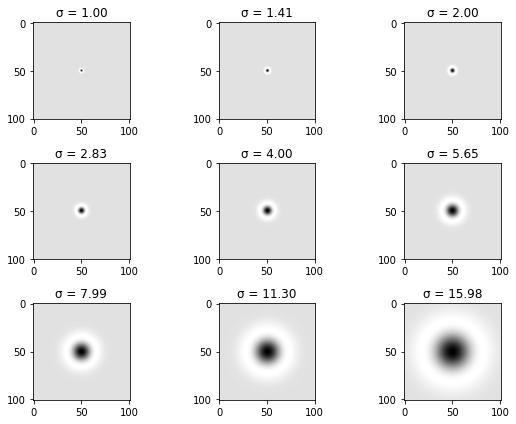

In [5]:
fig, ax = plt.subplots(3, 3, figsize=(8, 6))
for i in range(9):
    ax[np.unravel_index(i, (3, 3))].imshow(LoG(np.power(1.414,i)), cmap='gray')
    ax[np.unravel_index(i, (3, 3))].set_title(f'σ = {np.power(1.414,i):.2f}')
fig.tight_layout()

In [6]:
# 1D filter
def LoG_1D(x, sigma):
    filter = np.zeros(x.shape)
    filter = -1/np.pi/sigma**4*(1-(x**2)/2/sigma**2)*np.exp(-(x**2)/2/sigma**2)
    return filter

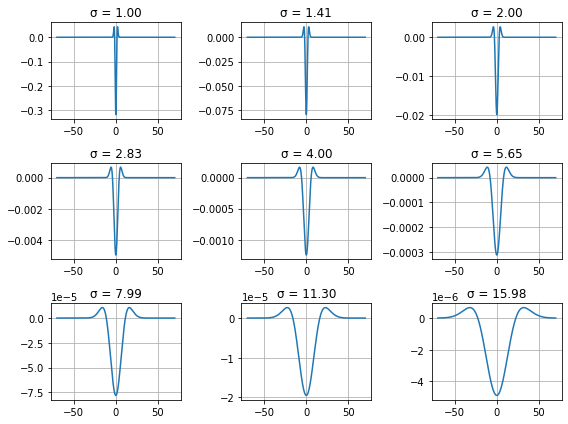

In [7]:
fig, ax = plt.subplots(3, 3, figsize=(8, 6))
x = np.arange(-70, 70, 0.1)
for i in range(9):
    ax[np.unravel_index(i, (3, 3))].plot(x, LoG_1D(x, np.power(1.414,i)))
    ax[np.unravel_index(i, (3, 3))].set_title(f'σ = {np.power(1.414,i):.2f}')
    ax[np.unravel_index(i, (3, 3))].grid()
fig.tight_layout()

In [8]:
# %%time
k = 1.414
sigma_start = 1.0
def LoG_convolve(img):
    log_images = [] #to store responses
    for i in range(0,9):
        sigma =  sigma_start * np.power(k,i) #sigma 
        filter = LoG(sigma) #filter generation
        image = cv2.filter2D(img,-1,filter) # convolving image
        image = np.pad(image,((1,1),(1,1)),'constant') #padding 
        image = np.square(image) 
        log_images.append(image)
    return np.array(log_images) 
log_image = LoG_convolve(img)

In [9]:
# %%time
def detect_blob(log_image, threshold=0.03):
    coordinates = [] #to store coordinates
    (h,w) = img.shape
    for i in range(1,h):
        for j in range(1,w):
            slice_img = log_image[:, i-1:i+2, j-1:j+2] #9*3*3 slice
            result = np.max(slice_img) #finding maximum
            if result >= threshold: #threshold
                z, x, y = np.unravel_index(slice_img.argmax(),slice_img.shape)
                coordinates.append((i+x-1, j+y-1, sigma_start * np.power(k, z)))
    return coordinates
coordinates = list(set(detect_blob(log_image)))

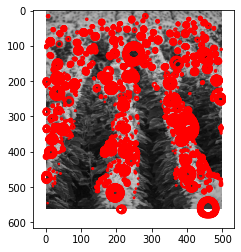

In [10]:
fig, ax = plt.subplots()
nh,nw = img.shape
ax.imshow(img, cmap="gray")
for blob in coordinates:
    y,x,s = blob
    c = plt.Circle((x, y), s*1.414, color='red', linewidth=1.5, fill=False)
    ax.add_patch(c)
ax.plot()
plt.show()

In [11]:
def blob_overlap(blob1, blob2):
    n_dim = len(blob1) - 1
    root_ndim = np.sqrt(n_dim)
    
    # radius of two blobs
    r1 = blob1[-1] * root_ndim
    r2 = blob2[-1] * root_ndim
    
    d = np.sqrt(np.sum((blob1[:-1] - blob2[:-1])**2))
    
    #no overlap between two blobs
    if d > r1 + r2:
        return 0
    # one blob is inside the other, the smaller blob must die
    elif d <= abs(r1 - r2):
        return 1
    else:
        #computing the area of overlap between blobs
        ratio1 = (d ** 2 + r1 ** 2 - r2 ** 2) / (2 * d * r1)
        ratio1 = np.clip(ratio1, -1, 1)
        acos1 = np.arccos(ratio1)
        ratio2 = (d ** 2 + r2 ** 2 - r1 ** 2) / (2 * d * r2)
        ratio2 = np.clip(ratio2, -1, 1)
        acos2 = np.arccos(ratio2)
        a = -d + r2 + r1
        b = d - r2 + r1
        c = d + r2 - r1
        d = d + r2 + r1
        area = (r1 ** 2 * acos1 + r2 ** 2 * acos2 -0.5 * np.sqrt(abs(a * b * c * d)))
        return area/(np.pi * (min(r1, r2) ** 2))

In [12]:
def redundancy(blobs_array, overlap):
    sigma = blobs_array[:, -1].max()
    distance = 2 * sigma * np.sqrt(blobs_array.shape[1] - 1)
    tree = spatial.cKDTree(blobs_array[:, :-1])
    pairs = np.array(list(tree.query_pairs(distance)))
    if len(pairs) == 0:
        return blobs_array
    else:
        for (i, j) in pairs:
            blob1, blob2 = blobs_array[i], blobs_array[j]
            if blob_overlap(blob1, blob2) > overlap:
                if blob1[-1] > blob2[-1]:
                    blob2[-1] = 0
                else:
                    blob1[-1] = 0
    return np.array([b for b in blobs_array if b[-1] > 0])

In [13]:
coordinates = np.array(coordinates)
coordinates = redundancy(coordinates,0.5)

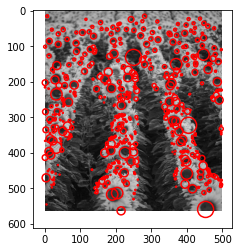

In [14]:
fig, ax = plt.subplots()
nh,nw = img.shape
ax.imshow(img, cmap="gray")
for blob in coordinates:
    y,x,s = blob
    c = plt.Circle((x, y), s*1.414, color='red', linewidth=1.5, fill=False)
    ax.add_patch(c)
ax.plot()
plt.show()

# Think Like experts!

In [15]:
!wget https://github.com/ghanbarzadeh/Course_MachineVision_2021/raw/master/resources/Widget.png

--2021-11-06 16:48:50--  https://github.com/ghanbarzadeh/Course_MachineVision_2021/raw/master/resources/Widget.png
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ghanbarzadeh/Course_MachineVision_2021/master/resources/Widget.png [following]
--2021-11-06 16:48:50--  https://raw.githubusercontent.com/ghanbarzadeh/Course_MachineVision_2021/master/resources/Widget.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8215 (8.0K) [image/png]
Saving to: ‘Widget.png’

Widget.png          100%[===================>]   8.02K  --.-KB/s    in 0s      

2021-11-06 16:48:50 (78.1 MB/s) - ‘Widget.png’ saved [82

In [16]:
img = cv2.imread("/content/Widget.png",0) #gray scale conversion
img = img/255.0  #image normalization

In [17]:
k = 1.414
sigma_start = 1.0

In [18]:
log_image = LoG_convolve(img)

In [19]:
coordinates = list(set(detect_blob(log_image, threshold=0.25)))

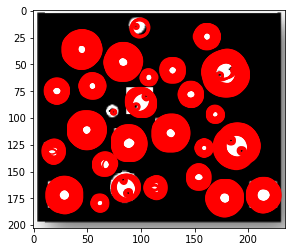

In [20]:
fig, ax = plt.subplots()
nh,nw = img.shape
ax.imshow(img, cmap="gray")
for blob in coordinates:
    y,x,s = blob
    c = plt.Circle((x, y), s*1.414, color='red', linewidth=1.5, fill=False)
    ax.add_patch(c)
ax.plot()
plt.show()

In [21]:
def remove_redundant(coordinates):
    unique_blobs = []
    for i in range(len(coordinates)):
        same = False
        y,x,s = coordinates[i]
        for j in range(len(unique_blobs)):
            y_, x_, s_ = unique_blobs[j]
            if abs(x-x_)<1.1*min(s*1.414, s_*1.414) and \
            abs(y-y_)<1.1*min(s*1.414, s_*1.414) and abs(s-s_)<10:
                same = True
        if not same:
            unique_blobs.append(coordinates[i])
    return unique_blobs

In [22]:
coordinates_ = np.array(coordinates)
coordinates_ = remove_redundant(coordinates_)

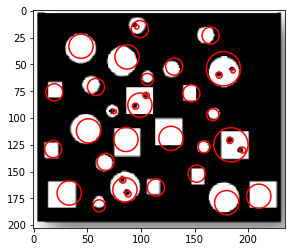

In [23]:
fig, ax = plt.subplots()
nh,nw = img.shape
ax.imshow(img, cmap="gray")
for blob in coordinates_:
    y,x,s = blob
    c = plt.Circle((x, y), s*1.414, color='red', linewidth=1.5, fill=False)
    ax.add_patch(c)
ax.plot()
plt.show()

In [35]:
def count_widgets(coordinates):
    holes = []
    widgets = []
    non_holed_widgets = []
    holed_widgets = []
    for i in range(len(coordinates)):
        y,x,s = coordinates[i]
        if s < 2:
            holes.append(coordinates[i])
        else:
            widgets.append(coordinates[i])
    for i in range(len(widgets)):
        hole = False
        y,x,s = widgets[i]
        for j in range(len(holes)):
            y_,x_,s_ = holes[j]
            d = np.sqrt((x-x_)**2 + (y-y_)**2)
            if d < s*1.414:
                hole = True
        if hole:
            holed_widgets.append(widgets[i])
        else:
            non_holed_widgets.append(widgets[i])
    print(f'Total number of widgets: {len(widgets)} ',
           f'\nwidgets with holes: {len(holed_widgets)} ',
           f'\nwidgets without holes: {len(non_holed_widgets)}')

In [36]:
count_widgets(coordinates_)

Total number of widgets: 26  
widgets with holes: 5  
widgets without holes: 21
